## Importing the CIFAR-100 dataset

In [17]:
import keras.datasets.cifar100
import numpy as np
from sklearn.preprocessing import LabelBinarizer

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


In [2]:

def standardize_data(x_train, x_test):
	mean = np.mean(x_train, axis=(0, 1, 2))
	std = np.std(x_train, axis=(0, 1, 2))

	x_train_stand = (x_train - mean) / std
	x_test_stand = (x_test - mean) / std

	return (x_train_stand, x_test_stand)


In [18]:
x_train = x_train / 255
x_test = x_test / 255

enc = LabelBinarizer()

y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)


In [22]:
print(x_test[0].shape)

(32, 32, 3)


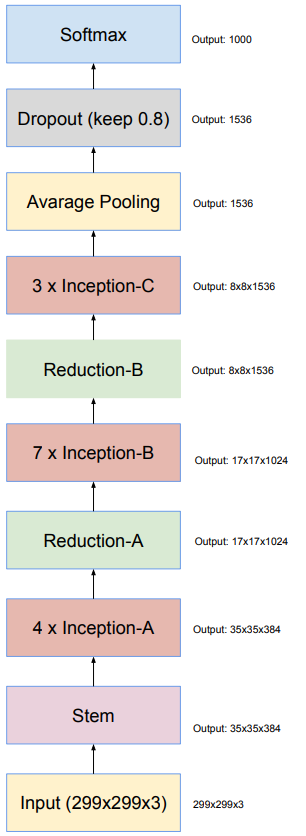

## Inception v4 Implementation

asd
[]
